In [1]:
!gdown https://drive.google.com/uc?id=1LQXGTRB174vrRbcBKSqrGA_XReSbIm_1
!unzip template-matching.zip
!gdown https://drive.google.com/uc?id=1c81QC9pEUYrVR8d1ZSVZ2Ux_Rwi_uia9

Downloading...
From: https://drive.google.com/uc?id=1LQXGTRB174vrRbcBKSqrGA_XReSbIm_1
To: /content/template-matching.zip
100% 682k/682k [00:00<00:00, 45.6MB/s]
Archive:  template-matching.zip
  inflating: template-matching/image1.jpg  
  inflating: template-matching/image2.jpg  
  inflating: template-matching/image3.jpg  
  inflating: template-matching/image4.jpg  
  inflating: template-matching/image5.jpg  
  inflating: template-matching/image6.jpg  
  inflating: template-matching/image7.jpg  
  inflating: template-matching/image8.jpg  
  inflating: template-matching/imagenet1000_clsid_to_human.pkl  
  inflating: template-matching/template.jpg  
  inflating: template-matching/template_cat1.jpg  
Downloading...
From: https://drive.google.com/uc?id=1c81QC9pEUYrVR8d1ZSVZ2Ux_Rwi_uia9
To: /content/imagenet1000_clsid_to_human.pkl
100% 35.5k/35.5k [00:00<00:00, 13.1MB/s]


In [43]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications.vgg16 import preprocess_input
from matplotlib import patches
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance

In [15]:
model = tf.keras.applications.VGG16(include_top=True, weights='imagenet', input_shape=(224, 224, 3))

PATH = '/content/template-matching/'
height = 550
width  = 1500
query = kimage.load_img(PATH+'image7.jpg', target_size=(height, width))

In [16]:
def compute_features(data):
  for i in range(1,19):
    data = model.layers[i](data)
  return data

def compute_prediction(data):
  for i in range(19,23):
    data = model.layers[i](data)
  return data

In [20]:
# compute features
query_np = kimage.img_to_array(query)
query_np = np.expand_dims(query, axis=0)
query_np = preprocess_input(query_np)

pred_query = compute_features(query_np)

In [34]:
# compute predictions
height = pred_query.shape[1]
width  = pred_query.shape[2]
side = 7
prediction_data = []

for i in tqdm(range(height-side+1)):
  for j in range(width-side+1):
    patch = pred_query[:, i:i+side, j:j+side, :]
    patch = compute_prediction(patch).numpy()
    prediction_data.append((patch[0].max(), i, j, patch[0].argmax()))

100%|██████████| 11/11 [00:02<00:00,  4.60it/s]


In [36]:
tp_s = sorted(prediction_data, key=lambda item: item[0], reverse=True)

In [38]:
labels = np.load(PATH+'imagenet1000_clsid_to_human.pkl', allow_pickle=True)

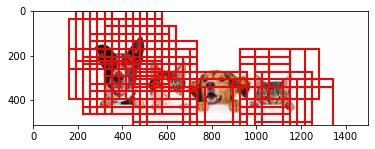

In [41]:
im = kimage.load_img(PATH+'image7.jpg', target_size=(510, 1500))

fig, ax = plt.subplots()
ax.imshow(im)

length = len(tp_s)

# Create a Rectangle patch
scale_height = 510//15
scale_width  = 1500//46
for i in range(length): 
  if (tp_s[i][0] > 0.4):
    rect = patches.Rectangle((tp_s[i][2]*scale_width,tp_s[i][1]*scale_height), 224, 224, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    #plt.text(tp_s[i][2]*scale_width-100, tp_s[i][1]*scale_height, labels[tp_s[i][3]])

plt.show()

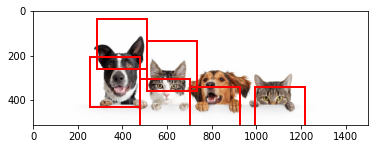

In [50]:
def check_duplication(i,j,data):
  result = False

  coord1 = (i,j)
  
  length = len(data)
  for k in range(length):
    coord2 = (data[k][1], data[k][2])
    dst = distance.euclidean(coord1, coord2)

    if (dst < 5):
      result = True
      break
  
  return result

def remove_duplication(data):
  result = []

  length = len(data)
  for k in range(length-1):
    duplicated = check_duplication(data[k][1], data[k][2], result)
    
    if (duplicated==False and data[k][0] > 0.45):
      result.append( data[k] )
    
    
  return result

result = remove_duplication(tp_s)

im = kimage.load_img(PATH+'image7.jpg', target_size=(510, 1500))

fig, ax = plt.subplots()
ax.imshow(im)

length = len(result)

# Create a Rectangle patch
scale_height = 510//15
scale_width  = 1500//46
for i in range(length):   
  rect = patches.Rectangle((result[i][2]*scale_width,result[i][1]*scale_height), 224, 224, linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  #plt.text(result[i][2]*scale_width-100, result[i][1]*scale_height, labels[result[i][3]])

plt.show()